## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# Global value
NUM_NEURONS = [512, 256, 128]
OUTPUT_UNITS = 10

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(NUM_NEURONS):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=OUTPUT_UNITS, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2, 0.5, 0.8]
redice_lr_patient = [ 5, 10, 25]

In [9]:
"""
# 載入 Callbacks, 並設定監控目標為 validation loss
"""
from keras.callbacks import ReduceLROnPlateau

import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0723 14:43:55.950024 12780 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 14:43:55.951021 12780 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 14:43:55.953017 12780 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 14:43:56.005902 12780 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 5


W0723 14:43:56.176446 12780 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 14:43:56.183400 12780 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0723 14:43:56.247231 12780 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 4s 71us/step - loss: 1.1924 - acc: 0.5882 - val_loss: 1.4731 - val_acc: 0.4825
Epoch 15/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.1689 - acc: 0.5949 - val_loss: 1.4641 - val_acc: 0.4850
Epoch 16/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.1461 - acc: 0.6033 - val_loss: 1.4635 - val_acc: 0.4899
Epoch 17/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.1219 - acc: 0.6133 - val_loss: 1.4599 - val_acc: 0.4881
Epoch 18/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.0989 - acc: 0.6209 - val_loss: 1.4516 - val_acc: 0.4928
Epoch 19/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.0770 - acc: 0.6302 - val_loss: 1.4519 - val_acc: 0.4930
Epoch 20/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.0562 - acc: 0.6381 - val_loss: 1.4473 - val_acc: 0.4995
Epoch 21/25
50000/50000 [=====================

50000/50000 [==============================] - 4s 84us/step - loss: 2.2067 - acc: 0.2653 - val_loss: 2.0456 - val_acc: 0.3159
Epoch 2/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.7508 - acc: 0.3891 - val_loss: 1.8101 - val_acc: 0.3804
Epoch 3/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.6252 - acc: 0.4301 - val_loss: 1.6862 - val_acc: 0.4123
Epoch 4/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.5494 - acc: 0.4576 - val_loss: 1.6428 - val_acc: 0.4258
Epoch 5/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.4950 - acc: 0.4780 - val_loss: 1.6100 - val_acc: 0.4335
Epoch 6/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.4526 - acc: 0.4917 - val_loss: 1.5754 - val_acc: 0.4453
Epoch 7/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.4105 - acc: 0.5067 - val_loss: 1.5631 - val_acc: 0.4494
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 4s 70us/step - loss: 0.9808 - acc: 0.6706 - val_loss: 1.4591 - val_acc: 0.4941
Epoch 25/25
50000/50000 [==============================] - 3s 69us/step - loss: 0.9604 - acc: 0.6793 - val_loss: 1.4592 - val_acc: 0.4972
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.2554 - acc: 0.5662 - val_loss: 1.4975 - val_acc: 0.4754
Epoch 13/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.2284 - acc: 0.5756 - val_loss: 1.4928 - val_acc: 0.4754
Epoch 14/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.2040 - acc: 0.5844 - val_loss: 1.4827 - val_acc: 0.4816
Epoch 15/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.1790 - acc: 0.5946 - val_loss: 1.4788 - val_acc: 0.4849
Epoch 16/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.1576 - acc: 0.6019 - val_loss: 1.4726 - val_acc: 0.4848
Epoch 17/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.1345 - acc: 0.6121 - val_loss: 1.4688 - val_acc: 0.4853
Epoch 18/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.1118 - acc: 0.6200 - val_loss: 1.4716 - val_acc: 0.4846
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 93us/step - loss: 2.2103 - acc: 0.2750 - val_loss: 2.1531 - val_acc: 0.3110
Epoch 2/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.7497 - acc: 0.3910 - val_loss: 1.8637 - val_acc: 0.3717
Epoch 3/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.6251 - acc: 0.4315 - val_loss: 1.7101 - val_acc: 0.4083
Epoch 4/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.5528 - acc: 0.4573 - val_loss: 1.6721 - val_acc: 0.4285
Epoch 5/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.4961 - acc: 0.4782 - val_loss: 1.6027 - val_acc: 0.4389
Epoch 6/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.4507 - acc: 0.4947 - val_loss: 1.5849 - val_acc: 0.4486
Epoch 7/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.4087 - acc: 0.5103 - val_loss: 1.5670 - val_acc

50000/50000 [==============================] - 4s 86us/step - loss: 0.5252 - acc: 0.8422 - val_loss: 1.4134 - val_acc: 0.5467
Epoch 24/25
50000/50000 [==============================] - 4s 85us/step - loss: 0.5185 - acc: 0.8454 - val_loss: 1.4183 - val_acc: 0.5462
Epoch 25/25
50000/50000 [==============================] - 4s 86us/step - loss: 0.5135 - acc: 0.8461 - val_loss: 1.4258 - val_acc: 0.5431
Numbers of exp: 10, reduce_factor: 0.20, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_lay

50000/50000 [==============================] - 4s 83us/step - loss: 1.1757 - acc: 0.6001 - val_loss: 1.4782 - val_acc: 0.4814
Epoch 11/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.1472 - acc: 0.6119 - val_loss: 1.4524 - val_acc: 0.4909
Epoch 12/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.1241 - acc: 0.6197 - val_loss: 1.4841 - val_acc: 0.4816
Epoch 13/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.0987 - acc: 0.6294 - val_loss: 1.4510 - val_acc: 0.4912
Epoch 14/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.0750 - acc: 0.6386 - val_loss: 1.4649 - val_acc: 0.4816
Epoch 15/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.0542 - acc: 0.6474 - val_loss: 1.4523 - val_acc: 0.4930
Epoch 16/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.0344 - acc: 0.6533 - val_loss: 1.4380 - val_acc: 0.4976
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.9801 - acc: 0.3312 - val_loss: 1.8913 - val_acc: 0.3637
Epoch 2/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.6316 - acc: 0.4303 - val_loss: 1.7032 - val_acc: 0.4197
Epoch 3/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.5405 - acc: 0.4616 - val_loss: 1.6307 - val_acc: 0.4385
Epoch 4/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.4794 - acc: 0.4845 - val_loss: 1.5930 - val_acc: 0.4476
Epoch 5/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.4351 - acc: 0.5008 - val_loss: 1.5784 - val_acc: 0.4502
Epoch 6/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.3960 - acc: 0.5146 - val_loss: 1.5494 - val_acc: 0.4600
Epoch 7/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.3637 - acc: 0.5268 - val_loss: 1.5249 - val_ac

50000/50000 [==============================] - 4s 81us/step - loss: 1.0736 - acc: 0.6390 - val_loss: 1.4523 - val_acc: 0.5010
Epoch 25/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.0606 - acc: 0.6424 - val_loss: 1.4457 - val_acc: 0.4978
Numbers of exp: 15, reduce_factor: 0.80, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2524 - acc: 0.5724 - val_loss: 1.4914 - val_acc: 0.4808
Epoch 13/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.2343 - acc: 0.5782 - val_loss: 1.4865 - val_acc: 0.4817
Epoch 14/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2150 - acc: 0.5854 - val_loss: 1.4792 - val_acc: 0.4867
Epoch 15/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.1984 - acc: 0.5924 - val_loss: 1.4799 - val_acc: 0.4818
Epoch 16/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.1831 - acc: 0.5988 - val_loss: 1.4667 - val_acc: 0.4859
Epoch 17/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.1653 - acc: 0.6055 - val_loss: 1.4701 - val_acc: 0.4869
Epoch 18/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.1517 - acc: 0.6112 - val_loss: 1.4623 - val_acc: 0.4862
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.7905 - acc: 0.3772 - val_loss: 2.0440 - val_acc: 0.3235
Epoch 2/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.5358 - acc: 0.4564 - val_loss: 3.2195 - val_acc: 0.1881
Epoch 3/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.4317 - acc: 0.4934 - val_loss: 2.1410 - val_acc: 0.3048
Epoch 4/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.3521 - acc: 0.5223 - val_loss: 2.1248 - val_acc: 0.3278
Epoch 5/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2988 - acc: 0.5425 - val_loss: 2.7616 - val_acc: 0.2260
Epoch 6/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.2400 - acc: 0.5628 - val_loss: 2.3312 - val_acc: 0.2943

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/25
50000/50000 [=====================

50000/50000 [==============================] - 4s 80us/step - loss: 1.4827 - acc: 0.4804 - val_loss: 1.6521 - val_acc: 0.4324
Epoch 23/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.4710 - acc: 0.4842 - val_loss: 1.6401 - val_acc: 0.4337
Epoch 24/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.4591 - acc: 0.4882 - val_loss: 1.6368 - val_acc: 0.4381
Epoch 25/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.4485 - acc: 0.4929 - val_loss: 1.6267 - val_acc: 0.4399
Numbers of exp: 20, reduce_factor: 0.20, reduce_patient: 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batc

Epoch 10/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.7007 - acc: 0.4106 - val_loss: 1.8085 - val_acc: 0.3797
Epoch 11/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.6732 - acc: 0.4205 - val_loss: 1.7811 - val_acc: 0.3898
Epoch 12/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.6489 - acc: 0.4276 - val_loss: 1.7608 - val_acc: 0.3922
Epoch 13/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.6268 - acc: 0.4353 - val_loss: 1.7461 - val_acc: 0.4005
Epoch 14/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.6063 - acc: 0.4413 - val_loss: 1.7310 - val_acc: 0.4021
Epoch 15/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.5876 - acc: 0.4496 - val_loss: 1.7213 - val_acc: 0.4058
Epoch 16/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.5701 - acc: 0.4543 - val_loss: 1.7081 - val_acc: 0.4091
Epoch 17/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 140us/step - loss: 2.5652 - acc: 0.1780 - val_loss: 2.3975 - val_acc: 0.2331
Epoch 2/25
50000/50000 [==============================] - 4s 88us/step - loss: 2.2227 - acc: 0.2559 - val_loss: 2.2233 - val_acc: 0.2736
Epoch 3/25
50000/50000 [==============================] - 4s 85us/step - loss: 2.0687 - acc: 0.2981 - val_loss: 2.1089 - val_acc: 0.3022
Epoch 4/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.9675 - acc: 0.3264 - val_loss: 2.0255 - val_acc: 0.3242
Epoch 5/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.8960 - acc: 0.3479 - val_loss: 1.9481 - val_acc: 0.3364
Epoch 6/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.8404 - acc: 0.3656 - val_loss: 1.9025 - val_acc: 0.3551
Epoch 7/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.7949 - acc: 0.3788 - val_loss: 1.8622 - val_ac

50000/50000 [==============================] - 4s 85us/step - loss: 1.4628 - acc: 0.4952 - val_loss: 1.6088 - val_acc: 0.4382
Epoch 25/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.4524 - acc: 0.4985 - val_loss: 1.6073 - val_acc: 0.4424
Numbers of exp: 25, reduce_factor: 0.80, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizat

50000/50000 [==============================] - 4s 85us/step - loss: 1.6706 - acc: 0.4209 - val_loss: 1.7652 - val_acc: 0.3895
Epoch 12/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.6474 - acc: 0.4279 - val_loss: 1.7466 - val_acc: 0.3947
Epoch 13/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.6258 - acc: 0.4348 - val_loss: 1.7330 - val_acc: 0.3997
Epoch 14/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.6065 - acc: 0.4407 - val_loss: 1.7156 - val_acc: 0.4069
Epoch 15/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.5878 - acc: 0.4479 - val_loss: 1.7036 - val_acc: 0.4093
Epoch 16/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.5702 - acc: 0.4541 - val_loss: 1.6931 - val_acc: 0.4123
Epoch 17/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.5548 - acc: 0.4592 - val_loss: 1.6798 - val_acc: 0.4176
Epoch 18/25
50000/50000 [=====================

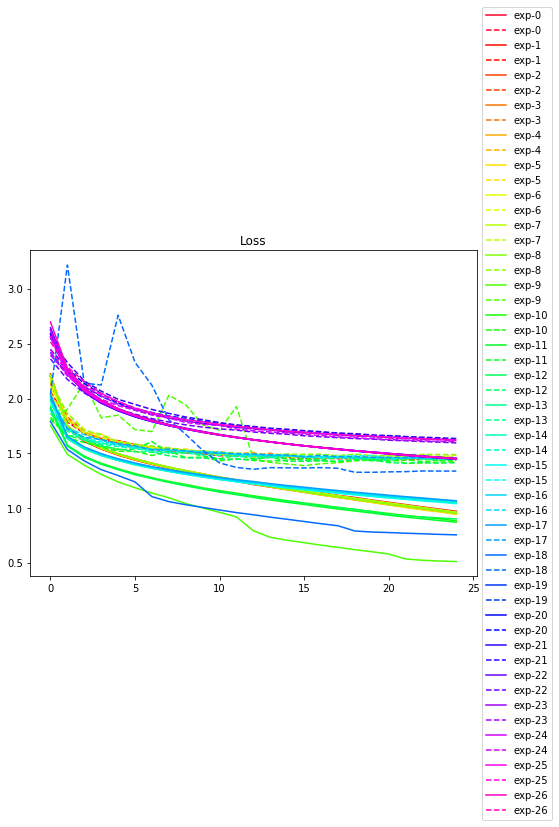

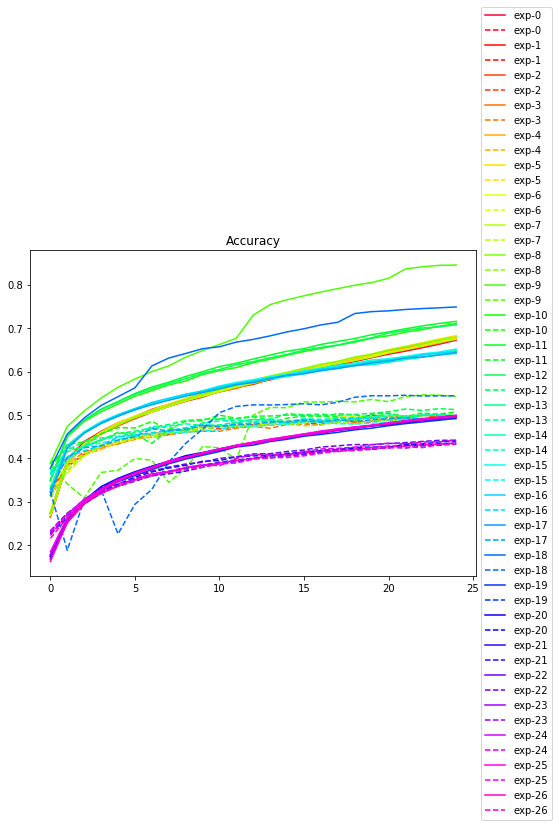

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()